# Майнор "Интеллектуальный анализ данных"

# Курс "Прикладные задачи анализа данных"

## Лабораторная работа №2. RecSys

Выполнил, Артём Суворов, 19БИ-3, ИАД2

В рамках данной лабораторной работы вам предлагается решить задачу рекомендательной системы на основе следующих данных:

* **rating.csv** - рейтинги аниме по 10 бальной шкале
* **anime.csv** - описание items

Скачать данные можно [здесь](https://drive.google.com/drive/u/1/folders/1FarHUuqQq4tQSlERB9K8uEfZAZT9tQWv)

In [1]:
!unzip archive.zip -d archive

Archive:  archive.zip
  inflating: archive/anime.csv       
  inflating: archive/rating.csv      


# Данные

Данные содержат информацию об предподчтениях 73,516 пользователей в 12,294 аниме. Каждый пользователь может добавить аниме и выставить рейтниг.

Anime.csv

* anime_id - идентификатор аниме (items)
* name - полное название аниме
* genre - категория/категории для аниме (разделены запятой).
* type - тип: movie, TV, OVA, etc.
* episodes - количество эпизодов (для экранизаций)
* rating - средний рейтинг по аниме.
* members - количество членов коммьюнити к аниме

Rating.csv

* user_id - идентификатор пользователя (users)
* anime_id - идентификатор аниме
* rating - рейтинг пользователя по аниме (-1 пользователь смотрел, но не оставил рейтинг).

### ``` Если вычеслительные ресурсы не позволяют решить задачу на всех данных, то необходимо это сделать на "сэмпле" данных (выбрав от 5% ids' для user и item). Этот же подход справедлив и для оценки работы алгоритомв```

In [2]:
import pandas as pd
import numpy as np
import os
import json
%matplotlib inline

In [3]:
"""Information Retrieval metrics
Useful Resources:
http://www.cs.utexas.edu/~mooney/ir-course/slides/Evaluation.ppt
http://www.nii.ac.jp/TechReports/05-014E.pdf
http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
http://hal.archives-ouvertes.fr/docs/00/72/67/60/PDF/07-busa-fekete.pdf
Learning to Rank for Information Retrieval (Tie-Yan Liu)
"""


def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def r_precision(r):
    """Score is precision after all relevant documents have been retrieved
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [4]:
anime = pd.read_csv('./archive/anime.csv')
rating = pd.read_csv('./archive/rating.csv')

## Необходимо сделать:

### Задание №1 : Exploratory analysis (2 балла):

* Распределение числа пользователей по количеству взаимодействий
* Разпределение числа "айтемов" по количеству взаимодействий
* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"
* и т.д. (бонус)

In [5]:
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [6]:
anime.anime_id = anime.anime_id.astype('int64')
anime.episodes = anime.episodes.replace('Unknown', np.NaN).astype('float32')
anime.rating = anime.rating.astype('float64')
anime.members = anime.members.astype('int64')

In [7]:
# топ аниме по эпизодам (с фильтрацией по эпизодом)

anime.sort_values(by='episodes', ascending=False)[['name', 'episodes']]

,name,episodes
6296,Oyako Club,1818.0
929,Doraemon (1979),1787.0
9243,Kirin Monoshiri Yakata,1565.0
5360,Manga Nippon Mukashibanashi (1976),1471.0
6580,Hoka Hoka Kazoku,1428.0
...,...,...
12265,Kyonyuu Reijou MC Gakuen,NaN
12274,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,NaN
12280,Saimin Class,NaN
12282,Shikkoku no Shaga The Animation,NaN


In [8]:
anime.episodes.value_counts()

# большинство аниме имеют 1 эпизод
# долгоиграющих тайтлов очень мало

1.0      5677
2.0      1076
12.0      816
13.0      572
26.0      514
         ... 
330.0       1
291.0       1
276.0       1
120.0       1
125.0       1
Name: episodes, Length: 186, dtype: int64

In [9]:
# отсортируем аниме по рейтингу

anime.sort_values(by='rating', ascending=False)[['name', 'rating']]

,name,rating
10464,Taka no Tsume 8: Yoshida-kun no X-Files,10.00
10400,Spoon-hime no Swing Kitchen,9.60
9595,Mogura no Motoro,9.50
0,Kimi no Na wa.,9.37
9078,Kahei no Umi,9.33
...,...,...
12274,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,NaN
12279,Sagurare Otome The Animation,NaN
12280,Saimin Class,NaN
12282,Shikkoku no Shaga The Animation,NaN


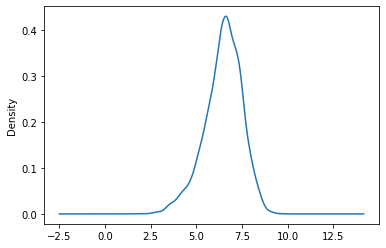

In [10]:
anime.rating.plot.kde()

# большая часть аниме имеет рейтинг чуть выше среднего

In [11]:
# топ аниме по комьюнити

anime.sort_values(by='members', ascending=False)[['name', 'members']]

,name,members
40,Death Note,1013917
86,Shingeki no Kyojin,896229
804,Sword Art Online,893100
1,Fullmetal Alchemist: Brotherhood,793665
159,Angel Beats!,717796
...,...,...
10464,Taka no Tsume 8: Yoshida-kun no X-Files,13
10424,Suijun Genten,13
10444,Sushi Azarashi,12
10990,Ganko-chan,11


In [12]:
rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [13]:
# кто оценил больше всех аниме

rating.user_id.value_counts()

48766    10227
42635     3747
53698     2905
57620     2702
59643     2633
         ...  
11323        1
48775        1
11328        1
48743        1
46734        1
Name: user_id, Length: 73515, dtype: int64

In [14]:
# средний рейтинг по каждому юзеру
# юзеры отсорированы от самых лояльных (с наибольшим средним) до хейтеров (с наименьшим средним)

rating.groupby('user_id').rating.mean().sort_values(ascending=False)

user_id
33952    10.0
64750    10.0
26194    10.0
54574    10.0
16328    10.0
         ... 
49040    -1.0
70404    -1.0
36635    -1.0
36639    -1.0
9421     -1.0
Name: rating, Length: 73515, dtype: float64

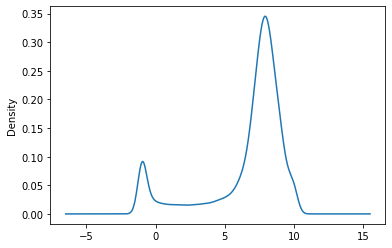

In [15]:
# распределение средних рейтингов

rating.groupby('user_id').rating.mean().plot.kde()

# видны пики в районе хейтеров и лояльных

In [16]:
# какое аниме оценили больше всего

rating.anime_id.value_counts().rename_axis('anime_id').reset_index(name='counts').merge(anime, on='anime_id')

,anime_id,counts,name,genre,type,episodes,rating,members
0,1535,39340,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37.0,8.71,1013917
1,11757,30583,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25.0,7.83,893100
2,16498,29584,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25.0,8.54,896229
3,1575,27718,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25.0,8.83,715151
4,226,27506,Elfen Lied,"Action, Drama, Horror, Psychological, Romance,...",TV,13.0,7.85,623511
...,...,...,...,...,...,...,...,...
11192,12781,1,Yoshimoto Muchikko Monogatari,Comedy,TV,47.0,5.62,88
11193,12767,1,Yuusei Kamen,Sci-Fi,TV,39.0,6.44,103
11194,12765,1,Yuuyake Banchou,Action,TV,26.0,6.36,109
11195,12763,1,0-sen Hayato,"Historical, Military",TV,38.0,6.25,147


In [17]:
# самые популярные жанры

all_genres = []

for genres in anime.genre.astype('str'):
    all_genres += genres.split(', ')

all_genres = pd.Series(all_genres)

all_genres.value_counts()

Comedy           4645
Action           2845
Adventure        2348
Fantasy          2309
Sci-Fi           2070
Drama            2016
Shounen          1712
Kids             1609
Romance          1464
School           1220
Slice of Life    1220
Hentai           1141
Supernatural     1037
Mecha             944
Music             860
Historical        806
Magic             778
Ecchi             637
Shoujo            603
Seinen            547
Sports            543
Mystery           495
Super Power       465
Military          426
Parody            408
Space             381
Horror            369
Harem             317
Demons            294
Martial Arts      265
Dementia          240
Psychological     229
Police            197
Game              181
Samurai           148
Vampire           102
Thriller           87
Cars               72
Shounen Ai         65
nan                62
Shoujo Ai          55
Josei              54
Yuri               42
Yaoi               39
dtype: int64

In [18]:
# средний рейтинг по жанру

all_genres_df = pd.DataFrame()
all_genres_df['name'] = all_genres.value_counts().index
all_genres_df['count'] = all_genres.value_counts().values

mean_rating = []

for genre_ith in all_genres.value_counts().index:
    animes = anime[anime.genre.str.contains(genre_ith, na=False)]
    mean_rating.append(animes.rating.mean())

all_genres_df['mean_rating'] = pd.Series(mean_rating)

all_genres_df.sort_values(by='mean_rating', ascending=False).head(10)

,name,count,mean_rating
41,Josei,54,7.443077
36,Thriller,87,7.382326
21,Mystery,495,7.232412
32,Police,197,7.122051
6,Shounen,1712,7.054642
31,Psychological,229,7.010398
23,Military,426,7.004904
12,Supernatural,1037,7.000380
8,Romance,1464,6.999054
40,Shoujo Ai,55,6.978148


In [19]:
# экономим RAM...
# возьмём топ пользователей по числу проставленных оценков

anime = pd.read_csv('./archive/anime.csv')
rating = pd.read_csv('./archive/rating.csv')

frac = 0.05

rating_length = rating.user_id.value_counts().shape[0]
num_rows = int(rating_length * frac)
print(num_rows)

top_users = rating.user_id.value_counts().head(num_rows).index
print(top_users)

rating = rating[rating.user_id.isin(top_users)]
anime = anime[anime.anime_id.isin(rating.anime_id)]

print(rating.shape, anime.shape)
print(rating.shape[0] * anime.shape[0])

3675
Int64Index([48766, 42635, 53698, 57620, 59643, 51693, 27364, 45659,  7345,
            66021,
            ...
            25773,  6222, 34879, 25165, 47385, 60673, 73359, 23351, 51661,
            35358],
           dtype='int64', length=3675)
(2158621, 3) (11157, 7)
24083734497


### Задание №2 : Оценить разреженность данных по рейтингу (1/2 балла)

In [20]:
sparse = rating.groupby(['user_id', 'anime_id'])['rating'].sum().unstack()

In [21]:
sparse.isna().sum().sum()

38854379

In [22]:
sparse.shape[0] * sparse.shape[1]

41013000

In [23]:
# процент незаполненных данных

sparse.isna().sum().sum() / (sparse.shape[0] * sparse.shape[1])

0.9473673957038012

In [24]:
del sparse # free up RAM

### Задание №3 : Разделить данные на тренировочные и валидационные (1/2 балла)

In [25]:
X_rating = rating[['user_id', 'anime_id']]
y_rating = rating[['rating']]

In [26]:
# т.к. у нас нет временной компоненты, то поделим данные традиционным образом

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_rating, y_rating, test_size=0.2, random_state=42)

In [27]:
train = X_train
train['rating'] = y_train

test = X_test
test['rating'] = y_test

### Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item (1 балл)

In [28]:
test_unique_users = test.user_id.unique()
test_unique_anime = test.anime_id.unique()

train_unique_users = train.user_id.unique()
train_unique_anime = train.anime_id.unique()

In [29]:
cold_users = [i for i in test_unique_users if i not in train_unique_users]
cold_items = [i for i in test_unique_anime if i not in train_unique_anime]

ranking_df = test.merge(train, on = ['user_id', 'anime_id'], how='left', suffixes=('', '_TrainRating'))
ranking_df['cold_users'] = ranking_df.user_id.map(lambda x: x in cold_users)
ranking_df['cold_items'] = ranking_df.anime_id.map(lambda x: x in cold_items)

ranking_table = ranking_df[(ranking_df.cold_items==False)&(ranking_df.cold_users==False)&(ranking_df.rating_TrainRating.isnull())]

ranking_table = ranking_table.groupby(['user_id'])['anime_id'].apply(lambda x: list(x)).to_frame().reset_index()

In [30]:
ranking_table

,user_id,anime_id
0,5,"[4437, 232, 189, 2789, 12673, 905, 5279, 24135..."
1,17,"[12531, 1852, 934, 25241, 6548, 777, 15951, 10..."
2,54,"[13333, 205, 12123, 18295, 189, 4744, 6707, 15..."
3,123,"[4866, 23325, 33241, 14719, 11663, 24991, 8476..."
4,160,"[4214, 4026, 2994, 4224, 6187, 7082, 6927, 790..."
...,...,...
3670,73408,"[437, 132, 969, 304, 3167, 395, 5152, 4970, 68..."
3671,73417,"[28621, 12467, 121, 4898, 4181, 15037, 12549, ..."
3672,73457,"[678, 9253, 18229, 7598, 4725, 9834, 543, 1015..."
3673,73499,"[16498, 12505, 5205, 596, 10737, 10479, 5955, ..."


In [31]:
# самые популярные аниме

most_popular_anime = list(train.groupby('anime_id')['rating'].mean().reset_index().sort_values(by='rating', ascending=False)['anime_id'][:10].values)
most_popular_anime

[3275, 34252, 6579, 33605, 23857, 31866, 8999, 30921, 33446, 33350]

In [32]:
ranking_table['most_popular'] = 1

ranking_table['most_popular'] = ranking_table['most_popular'].map(lambda x: most_popular_anime)

In [33]:
ranking_table.head()

,user_id,anime_id,most_popular
0,5,"[4437, 232, 189, 2789, 12673, 905, 5279, 24135...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,..."
1,17,"[12531, 1852, 934, 25241, 6548, 777, 15951, 10...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,..."
2,54,"[13333, 205, 12123, 18295, 189, 4744, 6707, 15...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,..."
3,123,"[4866, 23325, 33241, 14719, 11663, 24991, 8476...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,..."
4,160,"[4214, 4026, 2994, 4224, 6187, 7082, 6927, 790...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,..."


In [34]:
ranking_table['top_3_mp'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.most_popular[:3]], axis=1)
ranking_table['top_5_mp'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.most_popular[:5]], axis=1)
ranking_table['top_10_mp'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.most_popular[:10]], axis=1)

In [35]:
score_results_mp = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K'])

In [36]:
for top in [3, 5, 10]:
    score_results_mp.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_'+str(top)+'_mp'].values))
    score_results_mp.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_'+str(top)+'_mp'].values))
    score_results_mp.loc['top_'+str(top), 'NDCG@k'] = np.mean([ndcg_at_k(i, top) for i in list(ranking_table['top_'+str(top)+'_mp'].values)])

In [37]:
score_results_mp

,MRR,MAP@K,NDCG@k
top_3,0.000317,0.000363,0.000394
top_5,0.000432,0.000499,0.000657
top_10,0.000526,0.000605,0.000931


In [38]:
# самые популярные для каждого пользователя

In [39]:
most_popular_each = train.groupby('user_id').agg(lambda x: list(x))
most_popular_each = pd.DataFrame(sorted(zip(most_popular_each.anime_id, most_popular_each.rating), key=lambda x: x[1], reverse=True), index=most_popular_each.index, columns=['anime_id', 'rating'])
most_popular_each

,anime_id,rating
user_id,,
5,"[1686, 20, 7561, 10863, 7017, 11209, 10217, 10...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
17,"[16762, 6205, 27601, 2178, 6793, 4063, 30831, ...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
54,"[5081, 19685, 846, 14749, 1965, 8525, 30240, 2...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
123,"[20035, 11759, 12291, 7590, 23847, 22145, 5081...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
160,"[4182, 3588, 20787, 31859, 10924, 17909, 2528,...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1..."
...,...,...
73408,"[18677, 16592, 3974, 30384, 27655, 9938, 22147...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
73417,"[5310, 12079, 10519, 9656, 9201, 9731, 9581, 4...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
73457,"[4059, 9347, 1723, 9314, 20785, 7592, 9241, 90...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [40]:
def get_popular_anime_for_user(user_id):
    try:
        return most_popular_each[user_id].anime_id
    except KeyError:
        return most_popular_anime
        # если юзера нет в train, то вернём дефолтные популярные аниме

In [41]:
ranking_table['most_popular_each'] = ranking_table.user_id.map(lambda x: get_popular_anime_for_user(x))

In [42]:
ranking_table['top_3_mp_each'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.most_popular_each[:3]], axis=1)
ranking_table['top_5_mp_each'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.most_popular_each[:5]], axis=1)
ranking_table['top_10_mp_each'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.most_popular_each[:10]], axis=1)

In [43]:
score_results_mp_each = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K'])

In [44]:
for top in [3, 5, 10]:
    score_results_mp_each.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_'+str(top)+'_mp_each'].values))
    score_results_mp_each.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_'+str(top)+'_mp_each'].values))
    score_results_mp_each.loc['top_'+str(top), 'NDCG@k'] = np.mean([ndcg_at_k(i, top) for i in list(ranking_table['top_'+str(top)+'_mp_each'].values)])

In [45]:
score_results_mp_each

,MRR,MAP@K,NDCG@k
top_3,0.000317,0.000363,0.000394
top_5,0.000432,0.000499,0.000657
top_10,0.000526,0.000605,0.000931


### Задание №5 : Решить задачу на основе коллоборативной фильтрации (2 балла)

* Реализовать один из методов коллоборативной фильтрации SVD, SVD++, ALS, ALS with implicit feedback

In [46]:
def predict(
    algo,
    data,
    usercol,
    itemcol,
    predcol,
):
    """Computes predictions of an algorithm from Surprise on the data. Can be used for computing rating metrics like RMSE.
    
    Args:
        algo (surprise.prediction_algorithms.algo_base.AlgoBase): an algorithm from Surprise
        data (pd.DataFrame): the data on which to predict
        usercol (str): name of the user column
        itemcol (str): name of the item column
    
    Returns:
        pd.DataFrame: dataframe with usercol, itemcol, predcol
    """
    predictions = [
        algo.predict(getattr(row, usercol), getattr(row, itemcol))
        for row in data.itertuples()
    ]
    predictions = pd.DataFrame(predictions)
    predictions = predictions.rename(
        index=str, columns={"uid": usercol, "iid": itemcol, "est": predcol}
    )
    return predictions.drop(["details", "r_ui"], axis="columns")

In [47]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633716 sha256=28902552f02d16f00029b954653ef17c41ddca4b494ce984071b72d98dd213ec
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [48]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
import os

In [49]:
train_sup = Dataset.load_from_df(train,  reader=Reader(line_format='user item rating'))
train_sup = train_sup.build_full_trainset()

test_sup = Dataset.load_from_df(test, reader=Reader(line_format='user item rating'))

In [50]:
svd = SVD(random_state=0, n_factors=3, n_epochs=300, reg_all=0.0002)

# перепробовал разные комбинации эпохи-регуляризация, распределение рейтнгов не меняется
# даже если поставить 1 эпоху, 1 регуляризация, то все рейтинги будут в 5
# оставил конфиг, где должно быть переобучение, в надежде, что распределение выпрямится, но не вышло

In [51]:
%%time
svd.fit(train_sup)

CPU times: user 10min 27s, sys: 1.69 s, total: 10min 29s
Wall time: 10min 44s


In [52]:
predictions = predict(svd, test, usercol='user_id', itemcol='anime_id', predcol='pred')
predictions.head()

,user_id,anime_id,pred
0,39921,2728,5.000000
1,54073,18115,5.000000
2,73417,28621,5.000000
3,12792,10083,1.249092
4,4565,1689,5.000000


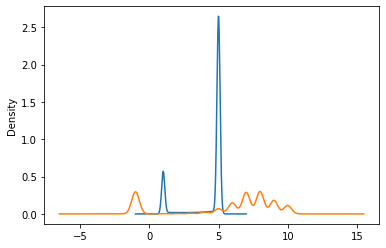

In [53]:
predictions.pred.plot.kde()
test.rating.plot.kde()

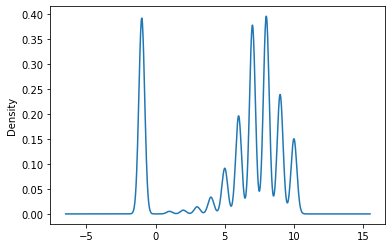

In [54]:
train.rating.plot.kde()

In [55]:
import torch

In [56]:
def compute_ranking_predictions(
    algo,
    data,
    usercol,
    itemcol,
    predcol,
    remove_seen=False,
):
    """Computes predictions of an algorithm from Surprise on all users and items in data. It can be used for computing
    ranking metrics like NDCG.
    
    Args:
        algo (surprise.prediction_algorithms.algo_base.AlgoBase): an algorithm from Surprise
        data (pd.DataFrame): the data from which to get the users and items
        usercol (str): name of the user column
        itemcol (str): name of the item column
        remove_seen (bool): flag to remove (user, item) pairs seen in the training data
    
    Returns:
        pd.DataFrame: dataframe with usercol, itemcol, predcol
    """

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    preds_lst = []  # takes a lot of space

    data_user_unique = data[usercol].unique()
    data_item_unique = data[itemcol].unique()

    for user in data_user_unique:
        for item in data_item_unique:
            preds_lst.append([user, item, algo.predict(user, item).est])
            
    all_predictions = pd.DataFrame(data=preds_lst, columns=[usercol, itemcol, predcol])
    del preds_lst  # free up RAM

    if remove_seen:
        tempdf = pd.concat(
            [
                data[[usercol, itemcol]],
                pd.DataFrame(data=np.ones(data.shape[0]), columns=["dummycol"], index=data.index),
            ],
            axis=1,
        )
        merged = pd.merge(tempdf, all_predictions, on=[usercol, itemcol], how="outer")
        return merged[merged["dummycol"].isnull()].drop("dummycol", axis=1)
    else:
        return all_predictions

In [57]:
train

,user_id,anime_id,rating
6900289,64242,18441,-1
3441391,31779,9366,5
2524523,23975,579,7
4900629,46906,27831,7
3185485,29430,79,9
...,...,...,...
7149836,66688,10079,-1
5697389,53455,884,10
2772349,26047,20583,-1
515414,5204,3407,5


In [58]:
%%time
svd.predict(train.iloc[0].user_id, train.iloc[0].anime_id)

CPU times: user 815 µs, sys: 0 ns, total: 815 µs
Wall time: 825 µs


Prediction(uid=64242, iid=18441, r_ui=None, est=1, details={'was_impossible': False})

In [59]:
train.user_id.nunique() * train.anime_id.nunique()

39796575

In [60]:
all_predictions = compute_ranking_predictions(svd, 
                                              train, 
                                              usercol='user_id', itemcol='anime_id', predcol='pred', remove_seen=True)
all_predictions.head()

,user_id,anime_id,pred
1726896,64242,9366,1.0
1726897,64242,579,1.0
1726898,64242,27831,1.0
1726899,64242,6637,1.0
1726900,64242,8876,1.0


In [61]:
all_predictions_final = all_predictions.sort_values(by='pred', ascending=False).groupby(['user_id'])['anime_id'].apply(lambda x: list(x)).to_frame().reset_index()

In [62]:
ranking_table = ranking_table.merge(all_predictions_final, on = ['user_id'], how='left', suffixes=['', '_pred'])

In [63]:
ranking_table['top_3_pred'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred[:3]], axis=1)
ranking_table['top_5_pred'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred[:5]], axis=1)
ranking_table['top_10_pred'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred[:10]], axis=1)

In [64]:
score_results_pred = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K'])

for top in [3, 5, 10]:
    score_results_pred.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_'+str(top)+'_pred'].values))
    score_results_pred.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_'+str(top)+'_pred'].values))
    score_results_pred.loc['top_'+str(top), 'NDCG@k'] = np.mean([ndcg_at_k(i, top) for i in list(ranking_table['top_'+str(top)+'_pred'].values)])

score_results_pred

,MRR,MAP@K,NDCG@k
top_3,0.028299,0.028435,0.040413
top_5,0.035476,0.035878,0.054688
top_10,0.041456,0.043417,0.071500


### Задание №6 Решить задачу на основе item- и content-based подходов, выбрав один из методов решения (2 балла):

* На основание векторов с факторизационной матрицы
* При помощи "ембеддингов"  item'ов

In [65]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.5 MB 9.8 MB/s 


In [66]:
from scipy.sparse import csr_matrix

id2user = {key: value for key, value in enumerate(train.user_id.unique())}
id2items = {key: value for key, value in enumerate(train.anime_id.unique())} # Get our unique products that were purchased

last_anime = train.groupby('user_id')['anime_id', 'rating'].apply(lambda x: x.head(5)).reset_index()
imp_rating = list(last_anime.rating)

user2id  = {value:key for key, value in id2user.items()}
items2id  = {value:key for key, value in id2items.items()}

rows = last_anime.user_id.map(user2id)
# Get the associated row indices
cols = last_anime.anime_id.map(items2id)
# Get the associated column indices

rating_sparse_last = csr_matrix((imp_rating, (rows, cols)), shape=(len(user2id), len(items2id)), dtype=np.float64)
rating_sparse_last

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


<3675x10829 sparse matrix of type '<class 'numpy.float64'>'
	with 18375 stored elements in Compressed Sparse Row format>

In [67]:
test['cold_users'] = test.user_id.map(lambda x: x in cold_users)
test['cold_items'] = test.anime_id.map(lambda x: x in cold_items)

test_result = test[(test.cold_items==False)&(test.cold_users==False)]
test_result = test_result.groupby(['user_id'])['anime_id'].apply(lambda x: list(x)).reset_index()

In [68]:
# решение на основе факторизационной матрицы. item-based

In [69]:
from implicit.als import AlternatingLeastSquares

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


In [70]:
ALS = AlternatingLeastSquares(num_threads=4, factors = 10, regularization=0.1)
ALS.fit(rating_sparse_last)

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:27: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/15 [00:00<?, ?it/s]

In [71]:
predict_factor = ALS.recommend_all(rating_sparse_last, filter_already_liked_items=True)

In [72]:
ranking_table['anime_id_pred_ALS'] = ranking_table.user_id.map(lambda x: predict_factor[user2id[x], :])
ranking_table['anime_id_pred_ALS'] = ranking_table.anime_id_pred_ALS.map(lambda x: [id2items[i] for i in x])

In [73]:
ranking_table['top_3_als'] = ranking_table.apply(lambda x: [int(pred in x.anime_id_pred_ALS) for pred in x.anime_id[:3]], axis=1)
ranking_table['top_5_als'] = ranking_table.apply(lambda x: [int(pred in x.anime_id_pred_ALS) for pred in x.anime_id[:5]], axis=1)
ranking_table['top_10_als'] = ranking_table.apply(lambda x: [int(pred in x.anime_id_pred_ALS) for pred in x.anime_id[:10]], axis=1)

In [74]:
score_results_als = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K', 'NDCG@k'])

for top in [3, 5, 10]:
    score_results_als.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_' + str(top) + '_als'].values))
    score_results_als.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_' + str(top) + '_als'].values))
    score_results_als.loc['top_'+str(top), 'NDCG@k'] = np.mean([ndcg_at_k(i, top) for i in list(ranking_table['top_' + str(top) + '_als'].values)])

score_results_als

,MRR,MAP@K,NDCG@k
top_3,0.021474,0.021497,0.029724
top_5,0.026104,0.026095,0.039227
top_10,0.032174,0.032511,0.055368


In [75]:
# решение на основе эмбеддингов. item-based
# CosineRecomender ломается

In [ ]:
corpus = list(train.groupby('user_id')['anime_id'].apply(lambda x: [str(i) for i in x]))

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(min_count=3, size = 10)
model.build_vocab(corpus)  # prepare the model vocabulary
model.train(corpus, total_examples=model.corpus_count, epochs=model.iter)  # train word vectors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


(8619815, 8634480)

In [ ]:
model.init_sims()

In [ ]:
emb_matrix = np.empty((len(model.wv.vocab), 10))

for i, key in enumerate(model.wv.vocab.keys()):
    emb_matrix[i, :]= model.wv.word_vec(key, use_norm=True)

In [ ]:
from implicit.nearest_neighbours import CosineRecommender

cos = CosineRecommender(K = 10, num_threads=1)

In [ ]:
cos.fit(emb_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
cos.num_threads

1

In [ ]:
some_id = train.user_id.astype(np.float64).iloc[0]
some_id

64242.0

In [ ]:
cos.recommend(some_id, rating_sparse_last, filter_already_liked_items=True)  # crashes runtime, if there was some filtering or sorting. strange things...

In [ ]:
def predict_cos(model, user, rating):
    res = model.recommend(user, rating, filter_already_liked_items=True)
    return res[0]
    # return [i for i, k in res]

In [ ]:
some_id_again = user2id[test_result.user_id[0]]
some_id_again

In [ ]:
predict_cos(cos, some_id_again, rating_sparse_last)

In [ ]:
ranking_table['anime_id_pred_word2vec'] = ranking_table.user_id.map(lambda x: predict_cos(cos, user2id[x], rating_sparse_last))

In [ ]:
ranking_table['top_3_emb'] = ranking_table.apply(lambda x: [int(pred in x.anime_id_pred_word2vec) for pred in x.anime_id[:3]], axis=1)
ranking_table['top_5_emb'] = ranking_table.apply(lambda x: [int(pred in x.anime_id_pred_word2vec) for pred in x.anime_id[:5]], axis=1)
ranking_table['top_10_emb'] = ranking_table.apply(lambda x: [int(pred in x.anime_id_pred_word2vec) for pred in x.anime_id[:10]], axis=1)

In [ ]:
score_results_emb = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K', 'NDCG@k'])

In [ ]:
for top in [3, 5, 10]:
    score_results_emb.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_'+str(top)+'_emb'].values))
    score_results_emb.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_'+str(top)+'_emb'].values))
    score_results_emb.loc['top_'+str(top), 'NDCG@k'] = np.mean([ndcg_at_k(i, top) for i in list(ranking_table['top_'+str(top)+'_emb'].values)])

In [ ]:
score_results_emb

In [76]:
# content-based

In [77]:
import tqdm
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader

In [78]:
# full_anime = pd.read_csv('./archive/anime.csv')
# full_rating = pd.read_csv('./archive/rating.csv')

full_data = rating.merge(anime, how='left', on='anime_id')
full_data

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,5,6,8,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069.0
1,5,15,6,Eyeshield 21,"Action, Comedy, Shounen, Sports",TV,145,8.08,83648.0
2,5,17,6,Hungry Heart: Wild Striker,"Comedy, Shounen, Slice of Life, Sports",TV,52,7.74,13469.0
3,5,18,6,Initial D Fourth Stage,"Action, Cars, Drama, Seinen, Sports",TV,24,8.24,41584.0
4,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297.0
...,...,...,...,...,...,...,...,...,...
2158616,73502,18893,9,Aoki Hagane no Arpeggio: Ars Nova,"Action, Sci-Fi, Seinen",TV,12,7.55,84708.0
2158617,73502,19151,5,Walkure Romanze,"Action, Ecchi, Harem, Romance, School, Sports",TV,12,6.56,56131.0
2158618,73502,19221,6,"Ore no Nounai Sentakushi ga, Gakuen Love Comed...","Comedy, Romance, School",TV,10,7.55,179569.0
2158619,73502,19367,6,Galilei Donna,"Action, Adventure, Sci-Fi",TV,11,6.50,39413.0


In [79]:
for genre in all_genres.unique():
    full_data[f'genre_is_{genre}'] = full_data.genre.str.contains(genre)

In [80]:
genre_cols = list(map(lambda name: f'genre_is_{name}', all_genres.unique()))

In [81]:
class Anime1MDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.user2id = {key: i for i, key in enumerate(np.unique(data['user_id']))}
        self.item2id = {key: i for i, key in enumerate(np.unique(data['anime_id']))}
        self.type2id = {key: i for i, key in enumerate(data['type'].unique())}
        
        data['user_id'] = data['user_id'].map(self.user2id)
        data['anime_id'] = data['anime_id'].map(self.item2id)
        data['type_id'] = data['type'].map(self.type2id)

        data['episodes'] = self.__preprocess_episodes(data.episodes)
               
        numpy_data = data[['anime_id', 'user_id', 'type_id', 'episodes', 'members'] + genre_cols].fillna(0).to_numpy()

        self.items = numpy_data.astype(np.int32)
        self.targets = self.__preprocess_target(data.rating_x.astype(np.float64))
        self.field_dims = np.max(self.items, axis=0) + 1
        
        self.user_field_idx = np.array((0, ), dtype=np.int64)
        self.item_field_idx = np.array((1, ), dtype=np.int64)

        self.data = data

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_episodes(self, episodes):
        return episodes.replace('Unknown', 'NaN').astype(np.float32)

    def __preprocess_target(self, target):
        target[target <= 3] = 0
        target[target > 3] = 1
        return target

In [82]:
class FactorizationMachineModel(torch.nn.Module):
    """
    A pytorch implementation of Factorization Machine.
    Reference:
        S Rendle, Factorization Machines, 2010.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = self.linear(x) + self.fm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

class FeaturesLinear(torch.nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias


class FeaturesEmbedding(torch.nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int64)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)

class FactorizationMachine(torch.nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix

In [83]:
class EarlyStopper(object):

    def __init__(self, num_trials, save_path):
        self.num_trials = num_trials
        self.trial_counter = 0
        self.best_accuracy = 0
        self.save_path = save_path

    def is_continuable(self, model, accuracy):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.trial_counter = 0
            torch.save(model, self.save_path)
            return True
        elif self.trial_counter + 1 < self.num_trials:
            self.trial_counter += 1
            return True
        else:
            return False

In [84]:
def train_model(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            tk0.set_postfix(loss=total_loss / log_interval)
            total_loss = 0

def test_model(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return roc_auc_score(targets, predicts)

def main(dataset,
         model_name,
         epoch,
         learning_rate,
         batch_size,
         weight_decay,
         device,
         save_dir
        ):
    device = torch.device(device)
    
    dataset = Anime1MDataset(dataset)
    train_length = int(len(dataset) * 0.8)
    valid_length = int(len(dataset) * 0.1)
    test_length = len(dataset) - train_length - valid_length
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_length, valid_length, test_length))
    field_dims = dataset.field_dims    
    
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)
    
    #field_dims = train_dataset.field_dims
    model = FactorizationMachineModel(field_dims, embed_dim=16).to(device)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    early_stopper = EarlyStopper(num_trials=2, save_path=f'{save_dir}/{model_name}.pt')
    for epoch_i in range(epoch):
        train_model(model, optimizer, train_data_loader, criterion, device)
        auc = test_model(model, valid_data_loader, device)
        print('epoch:', epoch_i, 'validation: auc:', auc)
        if not early_stopper.is_continuable(model, auc):
            print(f'validation: best auc: {early_stopper.best_accuracy}')
            break
    auc = test_model(model, test_data_loader, device)
    print(f'test auc: {auc}')

In [ ]:
main(dataset=full_data,
     model_name='fm',
     epoch=3,
     learning_rate=0.01,
     batch_size=256,
     weight_decay=0.001,
     device='cpu',
     save_dir='.'
    ) # takes 1h 21m. skip and load model from file

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 844/844 [00:08<00:00, 96.34it/s] 


epoch: 0 validation: auc: 0.9365844670627408


  0%|          | 0/6746 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 844/844 [00:09<00:00, 92.76it/s]


epoch: 1 validation: auc: 0.9361358476430977


  0%|          | 0/6746 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 844/844 [00:08<00:00, 94.24it/s]


epoch: 2 validation: auc: 0.9380116040181147


  0%|          | 0/844 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 844/844 [00:09<00:00, 85.78it/s]


test auc: 0.937231108937313


In [85]:
the_model = torch.load('./fm.pt')

In [86]:
the_model

FactorizationMachineModel(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(1030666, 16)
  )
  (linear): FeaturesLinear(
    (fc): Embedding(1030666, 1)
  )
  (fm): FactorizationMachine()
)

In [87]:
anime_loader = DataLoader(Anime1MDataset(full_data), batch_size=512, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [88]:
predict_all_the_model = None
target_all_the_model = None
all_fields = None
 
with torch.no_grad():
    for fields, target in tqdm.tqdm(anime_loader, smoothing=0, mininterval=1.0):
        pred = the_model(fields)
        if predict_all_the_model is None:
            predict_all_the_model = pred
        else:
            predict_all_the_model = torch.cat((predict_all_the_model, pred))

        if target_all_the_model is None:
            target_all_the_model = target
        else:
            target_all_the_model = torch.cat((target_all_the_model, target))

        if all_fields is None:
            all_fields = fields
        else:
            all_fields = torch.cat((all_fields, fields))

  0%|          | 0/4217 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 4217/4217 [05:04<00:00, 13.85it/s]


In [89]:
sum((predict_all_the_model - target_all_the_model) ** 2)

tensor(150203.3370, dtype=torch.float64)

In [90]:
sum((predict_all_the_model.round() - target_all_the_model) ** 2)

tensor(189309., dtype=torch.float64)

In [91]:
full_data.head(2)

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,genre_is_Drama,...,genre_is_Dementia,genre_is_Harem,genre_is_Cars,genre_is_Kids,genre_is_Shoujo Ai,genre_is_nan,genre_is_Hentai,genre_is_Yaoi,genre_is_Yuri,type_id
0,0,2,8,Trigun,"Action, Comedy, Sci-Fi",TV,26.0,8.32,283069.0,False,...,False,False,False,False,False,False,False,False,False,0
1,0,5,6,Eyeshield 21,"Action, Comedy, Shounen, Sports",TV,145.0,8.08,83648.0,False,...,False,False,False,False,False,False,False,False,False,0


In [92]:
all_fields
# 1-ая колонка - anime_id
# 2-ая колонка - user_id

tensor([[   2,    0,    0,  ...,    0,    0,    0],
        [   5,    0,    0,  ...,    0,    0,    0],
        [   7,    0,    0,  ...,    0,    0,    0],
        ...,
        [8023, 3674,    0,  ...,    0,    0,    0],
        [8049, 3674,    0,  ...,    0,    0,    0],
        [8050, 3674,    0,  ...,    0,    0,    0]], dtype=torch.int32)

In [93]:
# найти все оценки от пользователя, отсортированные по рейтингу
some_user_id = 3674

some_user_data = all_fields[all_fields[:, 1] == some_user_id]
some_user_anime = some_user_data[:, 0]

some_user_predict = the_model(some_user_data)

some_anime_and_pred = torch.cat((some_user_anime.unsqueeze(1), some_user_predict.unsqueeze(1)), 1)

some_anime_sorted_by_rating = some_anime_and_pred[some_anime_and_pred[:,1].argsort(descending=True)][:, 0]
some_anime_sorted_by_rating

# превратим это в функцию

tensor([7.3540e+03, 1.2440e+03, 4.1230e+03, 6.2640e+03, 7.8080e+03, 4.4600e+02,
        6.7250e+03, 6.0060e+03, 7.1290e+03, 7.1280e+03, 3.9480e+03, 3.6620e+03,
        5.6950e+03, 2.8550e+03, 6.9450e+03, 3.8110e+03, 2.8910e+03, 7.3630e+03,
        1.8390e+03, 4.2700e+03, 7.0080e+03, 6.0850e+03, 6.7160e+03, 6.9550e+03,
        1.2260e+03, 3.5580e+03, 2.5360e+03, 1.9860e+03, 4.5600e+02, 4.5560e+03,
        1.9780e+03, 5.8360e+03, 7.0940e+03, 6.0830e+03, 1.6580e+03, 4.9810e+03,
        4.8330e+03, 5.5240e+03, 1.7500e+02, 6.2400e+03, 2.8000e+02, 7.4950e+03,
        6.1340e+03, 2.6510e+03, 7.4200e+03, 4.3580e+03, 5.8790e+03, 1.6490e+03,
        5.0870e+03, 6.2470e+03, 6.6410e+03, 6.5610e+03, 5.7910e+03, 1.7130e+03,
        5.5340e+03, 1.4060e+03, 8.6500e+02, 7.1730e+03, 5.8250e+03, 3.7030e+03,
        4.3950e+03, 4.6140e+03, 2.2810e+03, 5.4070e+03, 6.7480e+03, 7.4370e+03,
        7.0260e+03, 7.6400e+02, 1.8100e+02, 1.5320e+03, 5.3530e+03, 2.0200e+02,
        4.2660e+03, 6.5380e+03, 4.7840e+

In [94]:
def predict_the_model(user_id):
    user_data = all_fields[all_fields[:, 1] == user_id]
    user_anime = user_data[:, 0]

    user_predict = the_model(user_data)

    anime_and_pred = torch.cat((user_anime.unsqueeze(1), user_predict.unsqueeze(1)), 1)

    anime_sorted_by_rating = anime_and_pred[anime_and_pred[:,1].argsort(descending=True)][:, 0]
    # будем возвращать только 20 аниме, чтобы экономить память
    return anime_sorted_by_rating[:20].tolist()

In [95]:
ranking_table['anime_id_pred_the_model'] = ranking_table.user_id.map(lambda x: predict_the_model(x))

In [96]:
ranking_table['top_3_pred_the_model'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred_the_model[:3]], axis=1)
ranking_table['top_5_pred_the_model'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred_the_model[:5]], axis=1)
ranking_table['top_10_pred_the_model'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred_the_model[:10]], axis=1)

In [97]:
score_results_the_model = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K', 'NDCG@k'])

for top in [3, 5, 10]:
    score_results_the_model.loc['top_'+str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_'+str(top)+'_pred_the_model'].values))
    score_results_the_model.loc['top_'+str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_'+str(top)+'_pred_the_model'].values))
    score_results_the_model.loc['top_'+str(top), 'NDCG@k'] = np.mean([ndcg_at_k(i, top) for i in list(ranking_table['top_'+str(top)+'_pred_the_model'].values)])

In [98]:
score_results_the_model

,MRR,MAP@K,NDCG@k
top_3,0.000136,0.000136,0.000272
top_5,0.00034,0.00034,0.00068
top_10,0.00042,0.00042,0.000876


### Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (2 балла):

* MAP@k
* NDCG@k
* MRR

In [99]:
score_results_mp

,MRR,MAP@K,NDCG@k
top_3,0.000317,0.000363,0.000394
top_5,0.000432,0.000499,0.000657
top_10,0.000526,0.000605,0.000931


In [100]:
score_results_mp_each

,MRR,MAP@K,NDCG@k
top_3,0.000317,0.000363,0.000394
top_5,0.000432,0.000499,0.000657
top_10,0.000526,0.000605,0.000931


In [101]:
score_results_pred

,MRR,MAP@K,NDCG@k
top_3,0.028299,0.028435,0.040413
top_5,0.035476,0.035878,0.054688
top_10,0.041456,0.043417,0.071500


In [102]:
score_results_als

,MRR,MAP@K,NDCG@k
top_3,0.021474,0.021497,0.029724
top_5,0.026104,0.026095,0.039227
top_10,0.032174,0.032511,0.055368


In [103]:
score_results_the_model

,MRR,MAP@K,NDCG@k
top_3,0.000136,0.000136,0.000272
top_5,0.00034,0.00034,0.00068
top_10,0.00042,0.00042,0.000876


In [104]:
# SVD - лучшая модель по всем метрикам
# SVD применялась при колаборативной фильтрации

# в работе модели есть странности - она не ставит рейтинги более 5 (макс. 10)

``` Бонус (1 балл) - дополнительные графики и характеристики в EDA и правильно сделанные выводы```

# ```Дедлайн - 08 июня 23:59```

In [105]:
ranking_table

,user_id,anime_id,most_popular,top_3_mp,top_5_mp,top_10_mp,most_popular_each,top_3_mp_each,top_5_mp_each,top_10_mp_each,...,top_5_pred,top_10_pred,anime_id_pred_ALS,top_3_als,top_5_als,top_10_als,anime_id_pred_the_model,top_3_pred_the_model,top_5_pred_the_model,top_10_pred_the_model
0,5,"[4437, 232, 189, 2789, 12673, 905, 5279, 24135...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[13759, 11111, 2904, 11887, 9919, 164, 14813, ...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[7807.0, 10808.0, 7129.0, 9035.0, 10617.0, 600...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,17,"[12531, 1852, 934, 25241, 6548, 777, 15951, 10...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5680, 2025, 17265, 7791, 5341, 30, 8425, 8676...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[5792.0, 10617.0, 3948.0, 8962.0, 9705.0, 1839...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,54,"[13333, 205, 12123, 18295, 189, 4744, 6707, 15...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[7791, 30, 6956, 1210, 430, 2759, 5081, 30276,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[9598.0, 7354.0, 7807.0, 10808.0, 9980.0, 5318...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,123,"[4866, 23325, 33241, 14719, 11663, 24991, 8476...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[28121, 20787, 8841, 1535, 11785, 6746, 13759,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[6464.0, 8488.0, 3948.0, 6610.0, 9705.0, 10363...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,160,"[4214, 4026, 2994, 4224, 6187, 7082, 6927, 790...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1575, 22789, 8676, 8425, 17265, 5680, 10620, ...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[7807.0, 449.0, 6725.0, 186.0, 7129.0, 3948.0,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670,73408,"[437, 132, 969, 304, 3167, 395, 5152, 4970, 68...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2904, 11111, 18277, 4280, 20787, 2001, 11785,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",[],[],[],[]
3671,73417,"[28621, 12467, 121, 4898, 4181, 15037, 12549, ...","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[3275, 34252, 6579, 33605, 23857, 31866, 8999,...","[0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"